# Library

In [80]:
import time
import datetime
from datetime import datetime, timedelta

import re
import gc

import json

import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import sys

%matplotlib inline
import matplotlib.pyplot as plt

import random 
from random import sample

rus_mon_dict = {'янв': '01', 'фев': '02', 'мар': '03',
                'апр': '04', 'мая': '05', 'июн': '06',
                'июл': '07', 'авг': '08', 'сен': '09',
                'окт': '10', 'ноя': '11', 'дек': '12'}

## Folders & Files

In [81]:
# pathes
art_project_path = '/content/drive/MyDrive/Art/Art_Project'
art_project_path_backups = '/content/drive/MyDrive/Art/Art_Project/parsing_backups'
art_project_path_tests = '/content/drive/MyDrive/Art/Art_Project/parsing_tests'

# files
page_s = '/page_parsing_status.csv'

artinvest_s = '/artinvest_pages_counter_stat.csv'
artinvest_d = '/artinvest_news_articles_data.csv'
artinvest_lt = '/artinvest_long_text.csv'
artinvest_w = '/artinvest_with_long_text.csv'

theartnewspaper_d = '/theartnewspaper_data_new.csv'
theartnewspaper_lt = '/theartnewspaper_long_text.csv'
theartnewspaper_w = '/theartnewspaper_with_long_text.csv'

artchive_s = '/artchive_pages_counter_stat.csv'
artchive_d = '/artchive_news_articles_data.csv'
artchive_lt = '/artchive_long_text.csv'
artchive_w = '/artchive_with_long_text.csv'

artuzel_s = '/artusel_pages_counter_stat.csv'
artuzel_d = '/artuzel_news_articles_data.csv'
artuzel_lt = '/artuzel_long_text.csv'
artuzel_w = '/artuzel_with_long_text.csv'

## Sites' list for parsing

In [82]:
urls_news = ['https://www.theartnewspaper.ru/', 'https://artinvestment.ru/', 'http://artuzel.com/', 'https://artchive.ru/'] # 'https://artguide.com/', 'http://artuzel.com/', 
# https://artguide.com/ - <div class="chromeframe">
#    Ваш браузер <em>устарел!</em> <a href="http://browsehappy.com/">Установите другой браузер</a> или
#    <a href="http://www.google.com/chromeframe/?redirect=true">Google Chrome Frame</a>, чтобы просматривать этот сайт.
urls_datasets = ['https://artchive.ru/', 'https://artinvestment.ru/', 'http://artuzel.com/']
urls_archives = ['https://artchive.ru/', 'https://russianartarchive.net/ru'] # есть API - https://api.raan.garagemca.org/documentation/#/
urls_fairs = ['https://www.cosmoscow.com/ru/']

In [83]:
# topping up dict (manually yet)
#                             site,       s_file,        d_file,        lt_file
df_dict = {'https://www.theartnewspaper.ru/': ['-', theartnewspaper_d, theartnewspaper_lt], 
           'https://artinvestment.ru/': [artinvest_s, artinvest_d, artinvest_lt],
           'https://artchive.ru/': [artchive_s, artchive_d, artchive_lt],
           'https://artuzel.com/': [artuzel_s, artuzel_d, artuzel_lt]
           }

# Unused code

In [ ]:
# drop part of df
#artinvest_news_articles_data = artinvest_news_articles_data.drop(artinvest_news_articles_data[artinvest_news_articles_data['page_url']=='20220209_Hirst.html'].index)

In [ ]:
# delete all data from df
#artinvest_news_articles_data = artinvest_news_articles_data[0:0]
#theartnewspaper_data = theartnewspaper_data[0:0]

In [ ]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

# Functions

## Openings and savings
1. __open_parsing_dict()__ -> parsing_dict - Open dict with sites for parsing
2. __open_file_csv(file, folder)__ -> df - Open file.csv
3. __save_df_file(df, file, folder)__ -> - Save df to csv file
4. __open_long_text_url_list_temp()__ -> parsing_list - Open json artinvest_long_text_url_list_temp
5. __save_long_text_url_list_temp(parsing_list)__ -> - Save json artinvest_long_text_url_list_temp
6. __date_transfomation(cell)__ -> cell - Date transfomation

In [84]:
# 1. Open dict with sites for parsing
def open_parsing_dict():
  with open(art_project_path + '/sites_for_parsing.txt', 'rb') as infile:
    parsing_dict = json.load(infile)
  return parsing_dict

# 2. Open file.csv
def open_file_csv(file, folder): # folder: live, backup or test
  if folder=='live':
    df = pd.read_csv(art_project_path + file)
  elif folder=='backup':
    df = pd.read_csv(art_project_path_backups + file)
  elif folder=='test':
    df = pd.read_csv(art_project_path_tests + file)
  return df

# 3. Save df to csv file
def save_df_file(df, file, folder): # folder: live, backup or test
  if folder=='live':
    df.to_csv(art_project_path + file, index=False)
  elif folder=='backup':
    df.to_csv(art_project_path_backups + file, index=False)
  elif folder=='test':
    df.to_csv(art_project_path_tests + file, index=False)

# 4. Open json long_text_url_list_temp
def open_long_text_url_list_temp():
  with open(art_project_path + '/long_text_url_list_temp.txt', 'rb') as infile:
    parsing_list = json.load(infile)
  return parsing_list

# 5. Save json long_text_url_list_temp
def save_long_text_url_list_temp(parsing_list):
  with open(art_project_path + '/long_text_url_list_temp.txt', 'w') as outfile:
    json.dump(parsing_list, outfile)

In [85]:
# 6. Date transfomation
def date_transfomation(cell):
  try:
    cell = pd.to_datetime(datetime.strptime(cell, '%d.%m.%Y').strftime('%Y-%m-%d')).date()
  except ValueError:
    cell = pd.to_datetime(cell).date()
  return cell

## Text transformations
7. **get_cat(df)** -> df - Getting category: news or articles

In [86]:
# 7. Getting category: news or articles
def get_cat(df):
  sites = open_parsing_dict() # 1. Open dict with sites for parsing
  news_cat_list = []
  for k1, v1 in sites.items():
    for k2, v2 in v1.items():
      if k2=='news':
        for k3, v3 in v2.items():
          if k3=='links':
            for link in v3:
              news_cat_list.append(link)

  df['news_article_cat'] = df['page_url'].dropna().apply(lambda x: 'news' if x in news_cat_list else 'articles')
  return df

### Text cleaning step 1

In [87]:
# 8. Text cleaning step 1 - remove invisible blanks, put blanks where it's needed

# move = dict.fromkeys((ord(c) for c in r'\xa0\n\t\u200d')) # don't replace on ' '

def replace_func(text): # goes before split !!!
#remove invisible blanks
  text = re.sub(r'\\n|\\r|\\tc|\\t|\\xa0|\\xad|\n|\r|\tc|\t|\xa0|\xad', ' ', text).replace(r'\\+', '').strip()
  text = text.replace(u'\\u200b', '').replace(u'\\u200e', '').replace(u'\u200b', '').replace(u'\u200e', '').replace(u'\\u2009', '').replace(u'\u2009', '').replace(u'\\u2028', '').replace(u'\u2028', '').replace(u'\\u2002', '').replace(u'\u2002', '').strip() # ' ' - ?? - no
  text = re.sub(r'\\\\\\', '', text) # (\\\ ) - check + #(\\)(\\)(\\)
  text = re.sub(r'\",\s\'', ' ', text) # (", ') - check + #(\")(,\s)(\')
  text = re.sub(r'\',\s\"', ' ', text) # (', ") - check + #(\')(,\s)(\")
  #text = re.sub(r'\",\s\"', ' ', text) # (", ") - artchive - ??
#put blanks where it's needed
  text = re.sub(r'(\s+)(\.)', r'\2', text) # Винсент ушел . - check - use strip() then !!!
  text = re.sub(r'(\.)([A-ZА-Я])([A-ZА-Яa-zа-я\s])', '. '+r'\2\3', text) # -> # ГМИИ им. А. С. Пушкина # S. M. A. K. - check +
  text = re.sub(r'(\.)([0-9]{1,2})(\s)', '. '+r'\2\3', text) # Синезубова.3 февраля # (Нью-Дели).27 мая - check +
  #text = re.sub(r'([^\.«-(\'\"])([A-ZА-Я])', r'\1'+' '+r'\2', text) # 1954Впервые # МоскваРаботы # (Арсенал)Выставка -> ГМ ИИ им. А.С. Пушкина # XV II I
  text = re.sub(r'([a-zа-я0-9)])([A-ZА-Я])', r'\1'+' '+r'\2', text) # 1954Впервые # МоскваРаботы # (Арсенал)Выставка -> Mac Dougall’s # «Му ХА» # Mo MA - check !
  text = re.sub(r'([^(\'\"])([«])', r'\1'+' '+r'\2', text) # правительство.«Портрет Валли» - check +
  text = re.sub(r'([»"])([^\.,?!:;)\'\"])', r'\1'+' '+r'\2', text) # Баженовой»11 - check + "-?
  text = re.sub(r'([A-ZА-Яa-zа-я0-9])(w{3}\.)', r'\1'+' '+r'\2', text) # 2 июняwww.palazzorealemilano.it. - chec
  text = re.sub(r'([0-9]+)(\s+)([0-9]+)', r'\1\3', text) # .RU 14 апреля 2021. vs .RU 2 3 июня 2014. # 19 30–1970-е # 3 31-е vs 30 000 руб - check - 14600 000 рублей ??
  # doesn't work from the first time
  text = re.sub(r'<!--.*-->\.', '', text) #(<!--)(.*)(-->\.)# <!-- .style7 {font-size: 7pt } .ne w {cursor: pointer; cursor: hand } -->. - check ??
  return text

# 19.30-21. 00 vs 19.30-21.00.
# ( Aya Maria Urhammer , Mariella Ottosson)

def split_func(text): # в коллекциях. Олега. Кулика. 
  end_list = ['.', '?', '!', ',', ':', ';']
  if len(text[2:-2].split("', '")) > 0:
    texts_list = text[2:-2].split("', '")
    texts_list_new = [sent.strip() + '.' if len(sent.strip())>0 and sent.strip()[-1] not in end_list else sent.strip() for sent in texts_list]
    #text = ' '.join(texts_list_new)
  else:
    texts_list = text[2:-2].split('", "')
    texts_list_new = [sent.strip() + '.' if len(sent.strip())>0 and sent.strip()[-1] not in end_list else sent.strip() for sent in texts_list]
    #text = ' '.join(texts_list_new)

  #return text
  return texts_list_new # !!!!!!!!!!!!


def clean_text_1(df):
  for col in ['long_text', 'structure']:
    df[col] = df[col].dropna().apply(lambda x: ' '.join(replace_func(x).split()))
    ##df[col] = df[col].dropna().apply(lambda x: ' '.join(split_func(x).split())) # !!! -> split_func()
    #df[col] = df[col].dropna().apply(lambda x: split_func(x)) # !!! -> split_func()
    df[col] = df[col].dropna().apply(split_func)
  for col in ['short_text', 'title']:
    df[col] = df[col].dropna().apply(lambda x: ' '.join(replace_func(x).split()))

  return df

### Text cleaning step 2

In [88]:
# 9. Text cleaning step 2 - extra patterns removing

#theartnewspaper_w_text - long_text
  #Подписаться на новости. #Материалы по теме: ... # !!! tags in between !!!
  #... Свежий номер The Art Newspaper Russia можно купить здесь.
  #№98 Материал из газеты ...
  #The Art Newspaper Russia 03.09.2015. #Ада Мазоэро 03.09.2015. #Хилари М. Шитс 19.01.2022. #Клео Робертс -Комиредди 28.01.2022.

def pattern_func_tanp(text_list):
  text_list_new = []

  for ind, text in enumerate(text_list):
    text = text.strip()
    text = re.sub('Подписаться на новости.', '', text) # - check +
    text = re.sub('Материалы по теме: ', '', text) # - check +
    text = re.sub('Свежий номер The Art Newspaper Russia можно купить здесь.', '', text) # - check + in all 3 samples the same pattern
    text = re.sub(r'№[0-9]+\sМатериал\sиз\sгазеты\s', '', text) # - check + !!!!!!
    text = re.sub(r'<!--.*-->\.', '', text) # !!!!!!!! <!-- .style7 {font-size: 7pt } .ne w {cursor: pointer; cursor: hand } -->. - check ??
    if ind == 1:
      text = re.sub(r'(?:\s*)(?:The\sArt\sNewspaper\sRussia\s\d{2}\.\d{2}\.\d{4}\.)$', '.', text, flags=re.MULTILINE)
      text = re.sub(r'(?:\s*)(?:[А-ЯA-Z][а-яa-z]+\s)(?:[А-ЯA-Z]\.\s|[А-ЯA-Z][а-яa-z]+\s*-*\s*){0,1}(?:[А-ЯA-Z][а-яa-z]+\s\d{2}\.\d{2}\.\d{4}\.)$', '.', text, flags=re.MULTILINE)
    
    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)
  
  return text_list_new


# artuzel_news_articles_w_text
  #dubbles in strings but can be signs of images
  #blank strings

  #Над интервью работала … #Интервью подготовили … 
  #Интервью: … #Видеоверсия интервью:
  #Фотограф: … #Фото: … фото: … #Текст: … текст: … #Текст и фото: … #Источники: #Авторы: … Автор: … #Перевод: 
  #Материал подготовила … #Фото предоставлены …

def pattern_func_artuz(text_list):
  text_list_new = []

  for ind, text in enumerate(text_list):
    text = text.strip()
    if ind > 0:
      if text == text_list[ind-1]: #dubbles in strings but can be signs of images
        text = ''

    text = re.sub(r'^(?:Над\s){0,1}(?:[Ии]нтервью\s)(?:работал|подготовил)(?:.+)', '', text, flags=re.MULTILINE) # +
    text = re.sub(r'^(?:Видеоверсия\s){0,1}(?:[Ии]нтервью:)(?:.+)', '', text, flags=re.MULTILINE) # +
    text = re.sub(r'^(?:[Фф]ото|[Тт]екст|[Ии]сточник|[Аа]втор|[Пп]еревод)(?:граф|\sи\sфото|и|ы|ка){0,1}(?::.+)', '', text, flags=re.MULTILINE) # +
    text = re.sub(r'^(?:Материал|Фото)(?:\s)(?:подготов|предостав)(?:.+)', '', text, flags=re.MULTILINE) # +
    
    if len(text) > 0: #blank strings
      text_list_new.append(text)

  return text_list_new

  #Место проведения: -> no info #Даты: -> no info #Художники: -> no info #Организаторы: -> no info #names: -> no info
  #initials (with blank space or without) -> no info

def pattern_func_artuz_struct(text_list):
  text_list_new = []

  for text in text_list:
    text = text.strip()
    try:
      if len(text) < 25 and re.search(r':$', text, flags=re.MULTILINE)[0]==':':
      #if len(text) < 25 and re.search(r':$', text, flags=re.MULTILINE):
        text = ''
    except: pass

    text = re.sub(r'^(?:[A-ZА-Я]\.)(?:\s){0,1}(?:[A-ZА-Я]){0,1}(?:\.){0,1}(?:[:]){0,1}$', '', text, flags=re.MULTILINE) # - check +
    
    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)

  return text_list_new


#artchive_news_articles_w_text
  #Артхив: читайте нас в Телеграме и смотрите в Инстаграме (with . or not) …
  #Телеграме. #Инстаграме. #Facebook. #Instagram. #Здесь. здесь.
  # 1. # 10. - !!!!! - if text.isdigit()==True
  #Читать дальше global.move_popup_to_body(\'#id_popup_dotted_more_phg Gd BOfh RSJ\');

def pattern_func_artch(text_list):
  patterns_list = ['Телеграме.', 'Инстаграме.', 'Facebook.', 'Instagram.', 'Здесь.']
  text_list_new = []

  for text in text_list:
    text = text.strip()
    text = re.sub(r'(?:Артхив: читайте нас в Телеграме и смотрите в Инстаграме)(?:\.*)', '', text)
    text = re.sub(r'Читать дальше global.move_popup_to_body(.*);\s*', '', text)
    text = re.sub(r'^(?:\d+\.)$', '', text, flags=re.MULTILINE) # - check ?
    
    for pattern in patterns_list:
      if len(text)==len(pattern):
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)

  return text_list_new


#repeated sentences inside the string in 'Аналитика'

def dubbles_artch(text_list): # works but not always !!!! leave till nlp !!!
  punct_list = ['.', '?', '!']
  text_list_new = []

  for text in text_list:
    text = text.strip()
    text_new = []

    while len(text.split('. ')) > 1: # except the first line - shouldn't be a pattern
      text_split = text.split('. ')
      #if len(text_split[-1])>0 and
      pattern = text_split[-1][:-1] if text_split[-1][-1] in punct_list else text_split[-1] # the last line
      
      if text_split[-1] not in text_new: # can't use set
        text_new.append(text_split[-1]) # last lines list, then reverse it

      # except the last line which is the pattern
      text_split_new = [t.replace(pattern, '').strip() for t in text_split[:-1] if len(t.replace(pattern, '').strip())>0]
      text = '. '.join(text_split_new)

    text_new.append(text) # add the first line
    text_new.reverse()

    if len(text_list_new)==0: # list with lists !
      text_list_new.append(text_new)
      text_list_set = list(set(text_new))
    else:
      text_list_new.append([t for t in text_new if t in list(set(text_new) - set(text_list_set))])
      text_list_set = list(set(text_list_set + text_new))

  #text_list_new_new = [t for t in text for text in text_list_new]
  text_list_new_new = []
  for text in text_list_new:
    for t in text:
      text_list_new_new.append(t)

  return text_list_new_new


#artinvest_news_articles_w_text
  #<!-- .style7 {font-size: 7pt} .new {cursor: pointer; cursor: hand} -->.
  #td.style7 {font-size: 8pt; background:#ffffff;}.
  #… ARTinvestment.RU 14 сентября 2021.
  #Материал подготовила … Беседу вела … Вопросы задавала … Смотрите фоторепортаж с открытия выставки ...
  #Данный материал в оригинале вы можете посмотреть здесь.
  #Источники. … Источники: … Источник. … Источник: …
  #Редакция ARTinvestment.RU.
  #Денис Белькевич, AI. #Алексей Смирнов, специально для AI. #Перевод и адаптация — Денис Белькевич, AI.

def pattern_func_artinvest(text_list):
  text_list_new = []

  for ind, text in enumerate(text_list):
    text = text.strip()
    if ind == 0:
      text = re.sub(r'(?:\sARTinvestment\.\s{0,1}RU\s\d{1,2}\s[а-я]+\s\d{4})(?:[\s\.]*)', '. ', text) # - check +?
    
    text = re.sub(r'<!--.*-->\.', '', text) # - check +
    text = re.sub(r'td\.style.*{.*}\.', '', text) # - check +
    text = re.sub(r'(?:Редакция ARTinvestment\.RU|Данный материал в оригинале вы можете посмотреть здесь)(?:\.*)', '', text) # - check +
    
    text = re.sub(r'^(?:Материал подготовил|Беседу вел|Интервью провел|Вопросы задавал|Беседовал|Смотрите фоторепортаж с открытия выставки)(?:.*)', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:Источник)(?:и){0,1}(?:[:\.])(?:.*)', '', text, flags=re.MULTILINE) # - check +

    text = re.sub(r'(?:Перевод\sи\sадаптация\s—\s){0,1}(?:[А-ЯA-Z][а-яa-z]+)(?:\s[А-ЯA-Z][а-яa-z]+)(?:,\s)(?:специально\sдля\s){0,1}(?:AI)(?:\.*)', '', text) # - check +?
    text = re.sub(r'^(?:Комментарий\s){0,1}(?:AI\.)$', '', text, flags=re.MULTILINE) # - check +?

    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)
  
  return text_list_new


  #Д.К. #А.Д.: #Г. Ч.: #Э.:
  #1. #2. #... #10. #... #Часть 1. #Подробнее о лоте 8.
  #2,194. #↗.
  #здесь. #[email protected]. #ARTinvestment.RU.
  #artinvestment.ru.

def pattern_func_artinvest_struct(text_list):
  text_list_new = []
  
  for ind, text in enumerate(text_list):
    text = text.strip()
    if ind > 0:
      if text == text_list[ind-1]: #dubbles in strings but can be signs of images
        text = ''

    if text.isdigit()==True:
      text = ''

    text = re.sub(r'^(?:[A-ZА-Я]\.)(?:\s){0,1}(?:[A-ZА-Я]){0,1}(?:\.){0,1}(?:[:]){0,1}$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:Часть\s|Подробнее\sо\sлоте\s){0,1}(?:\d+\.)$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:\d+)(?:[,\s]\d+){1,}(?:\.)$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:[↗↘]*\.)$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:\[email protected\])(?:.*)$', '', text, flags=re.MULTILINE) # - check +
    text = re.sub(r'^(?:ARTinvestment\.RU|здесь|Комментарий редактора|Правила приема работ на аукцион AI можно посмотреть здесь)(?:\.*)$', '', text, flags=re.MULTILINE) # - check 
    text = re.sub(r'^(?:artinvestment\.ru)(?:.*)$', '', text, flags=re.MULTILINE)
    
    text = text.strip()
    if len(text) > 0:
      text_list_new.append(text)

  return text_list_new


def clean_text_2(df, name):
  if name=='tanp':
    #df['long_text'] = df['long_text'].dropna().apply(lambda x: pattern_func_tanp(x))
    df['long_text'] = df['long_text'].dropna().apply(pattern_func_tanp)
  elif name=='artuz':
    #df['long_text'] = df['long_text'].dropna().apply(lambda x: pattern_func_artuz(x))
    df['long_text'] = df['long_text'].dropna().apply(pattern_func_artuz)
    #df['structure'] = df['structure'].dropna().apply(lambda x: pattern_func_artuz_struct(pattern_func_artuz(x)))
    df['structure'] = df['structure'].dropna().apply(pattern_func_artuz).apply(pattern_func_artuz_struct)
  elif name=='artch':
    #df['long_text'] = df['long_text'].dropna().apply(lambda x: pattern_func_artch(x))
    df['long_text'] = df['long_text'].dropna().apply(pattern_func_artch)
    #df['structure'] = df['structure'].dropna().apply(lambda x: dubbles_artch(pattern_func_artch(x)))
    df['structure'] = df['structure'].dropna().apply(pattern_func_artch).apply(dubbles_artch)
  elif name=='artinvest':
    #df['long_text'] = df['long_text'].dropna().apply(lambda x: pattern_func_artinvest(x))
    df['long_text'] = df['long_text'].dropna().apply(pattern_func_artinvest)
    #df['structure'] = df['structure'].dropna().apply(lambda x: pattern_func_artinvest_struct(pattern_func_artinvest(x)))
    df['structure'] = df['structure'].dropna().apply(pattern_func_artinvest).apply(pattern_func_artinvest_struct)
  
  return df

### Tags cleaning

In [93]:
# 10. Tags cleaning

def replace_func_short(text): # goes before split !!!
  text = re.sub(r'\\n|\\r|\\tc|\\t|\\xa0|\\xad|\n|\r|\tc|\t|\xa0|\xad', ' ', text).strip()
  text.replace(u'\\u200b', ' ').replace(u'\\u200e', ' ').replace(u'\u200b', ' ').replace(u'\u200e', ' ').replace(u'\\u2009', ' ').replace(u'\u2009', ' ').replace(u'\\u2028', ' ').replace(u'\u2028', ' ').replace(u'\\u2002', ' ').replace(u'\u2002', ' ').strip()
  text = text.replace('#', '').lower()
  text = re.sub(r'\\\\\\', '', text) # (\\\ )
  text = re.sub(r'\",\s\'', ' ', text) # (", ')
  text = re.sub(r'\',\s\"', ' ', text) # (', ")
  text = re.sub(r'\",\s\"', ' ', text) # (", ")
  
  return text


def split_func_short(text):
  if len(text[2:-2].split("', '")) > 0:
    texts_list = text[2:-2].split("', '")
  else:
    texts_list = text[2:-2].split('", "')
    
  texts_list_new = [text for text in texts_list if len(text)>0]

  return texts_list_new

# find_pattern

In [ ]:
def find_pattern(cell, pattern):
  for line in cell:
    try:
      if re.search(pattern, line)[0]==pattern:
        cell = 1
        break
    except:
      cell = 0

  return cell

df['pattern'] = df['structure'].dropna().apply(lambda x: find_pattern(x, 'Свежий номер:'))

index_list = df.loc[(df['page_title']=='Новости')&(df['pattern']==1)].index.tolist()
len(index_list)

#sample_df = df.iloc[index_list]

3

# Preprocessing

## first time

In [89]:
# Opening first time - !!!!!!!!!!!!!!
start_t = time.time()

artinvest_news_articles_data = open_file_csv(artinvest_d, 'live') # 2. Open file.csv
artinvest_long_text_df = open_file_csv(artinvest_lt, 'live') # 2. Open file.csv

theartnewspaper_data = open_file_csv(theartnewspaper_d, 'live') # 2. Open file.csv
theartnewspaper_long_text_df = open_file_csv(theartnewspaper_lt, 'live') # 2. Open file.csv

artchive_news_articles_data = open_file_csv(artchive_d, 'live') # 2. Open file.csv
artchive_long_text_df = open_file_csv(artchive_lt, 'live') # 2. Open file.csv

artuzel_news_articles_data = open_file_csv(artuzel_d, 'live') # 2. Open file.csv
artuzel_long_text_df = open_file_csv(artuzel_lt, 'live') # 2. Open file.csv

# Data and long text df-s combining
artinvest_news_articles_w_text = artinvest_news_articles_data.merge(artinvest_long_text_df, on='long_text_url', how='left')
theartnewspaper_w_text = theartnewspaper_data.merge(theartnewspaper_long_text_df, on='long_text_url', how='left')
artchive_news_articles_w_text = artchive_news_articles_data.merge(artchive_long_text_df, on='long_text_url', how='left')
artuzel_news_articles_w_text = artuzel_news_articles_data.merge(artuzel_long_text_df, on='long_text_url', how='left')

artuzel_news_articles_w_text['date'] = artuzel_news_articles_w_text['structure'].dropna().apply(lambda x: x[2:12])
artuzel_news_articles_w_text['structure'] = artuzel_news_articles_w_text['structure'].dropna().apply(lambda x: x.replace(x[1:15], ''))

# Dates transformation and sorting
df_list = [artinvest_news_articles_w_text,
           theartnewspaper_w_text,
           artchive_news_articles_w_text,
           artuzel_news_articles_w_text]

for df in df_list:
  # transformation
  try:
    #df['parsing_date'] = df['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 6. Date transfomation
    df['parsing_date'] = df['parsing_date'].dropna().apply(date_transfomation) # 6. Date transfomation
  except: continue
  # sorting
  try:
    #df['date'] = df['date'].dropna().apply(lambda x: date_transfomation(x)) # 6. Date transfomation
    df['date'] = df['date'].dropna().apply(date_transfomation) # 6. Date transfomation
    #df.sort_values(by=['date'], inplace=True, ascending=False)
  except: continue

# topping up dict (manually yet)
combo_df_dict = {artinvest_lt: artinvest_news_articles_w_text,
                 theartnewspaper_lt: theartnewspaper_w_text,
                 artchive_lt: artchive_news_articles_w_text,
                 artuzel_lt: artuzel_news_articles_w_text
                 }

for name, df in combo_df_dict.items():
  df['parsing_sec_speed_2'] = df['parsing_sec_speed_2'].dropna().apply(lambda x: float(x[1:-1]))
  
print('{} seconds have passed'.format(time.time() - start_t))

13.447701930999756 seconds have passed


In [90]:
start_t = time.time()
for df in combo_df_dict.values():
  df = get_cat(df) # 7. Getting category: news or articles
  print('{} seconds have passed'.format(time.time() - start_t))
  df = clean_text_1(df) # 8. Text cleaning step 1 - remove invisible blanks, put blanks where it's needed
print('{} seconds have passed'.format(time.time() - start_t))

0.01254415512084961 seconds have passed
19.937023639678955 seconds have passed
21.891486883163452 seconds have passed
30.47540307044983 seconds have passed
38.26789164543152 seconds have passed


In [91]:
# 9. Text cleaning step 2 - extra patterns removing
start_t = time.time()
theartnewspaper_w_text = clean_text_2(theartnewspaper_w_text, 'tanp')
artuzel_news_articles_w_text = clean_text_2(artuzel_news_articles_w_text, 'artuz')
artchive_news_articles_w_text = clean_text_2(artchive_news_articles_w_text, 'artch')
artinvest_news_articles_w_text = clean_text_2(artinvest_news_articles_w_text, 'artinvest')
print('{} seconds have passed'.format(time.time() - start_t))

14.097604513168335 seconds have passed


## next times

In [ ]:
# Opening next times
start_t = time.time()

theartnewspaper_w_text = open_file_csv(theartnewspaper_w, 'live')
artuzel_news_articles_w_text = open_file_csv(artuzel_w, 'live')
artchive_news_articles_w_text = open_file_csv(artchive_w, 'live')
artinvest_news_articles_w_text = open_file_csv(artinvest_w, 'live')

# Dates transformation and sorting
df_list = [artinvest_news_articles_w_text,
           theartnewspaper_w_text,
           artchive_news_articles_w_text,
           artuzel_news_articles_w_text]

for df in df_list:
  # transformation
  try:
    #df['parsing_date'] = df['parsing_date'].dropna().apply(lambda x: date_transfomation(x)) # 6. Date transfomation
    df['parsing_date'] = df['parsing_date'].dropna().apply(date_transfomation) # 6. Date transfomation
  except: continue
  # sorting
  try:
    #df['date'] = df['date'].dropna().apply(lambda x: date_transfomation(x)) # 6. Date transfomation
    df['date'] = df['date'].dropna().apply(date_transfomation) # 6. Date transfomation
    #df.sort_values(by=['date'], inplace=True, ascending=False)
  except: continue

# topping up dict (manually yet)
combo_df_dict = {artinvest_lt: artinvest_news_articles_w_text,
                 theartnewspaper_lt: theartnewspaper_w_text,
                 artchive_lt: artchive_news_articles_w_text,
                 artuzel_lt: artuzel_news_articles_w_text
                 }

print('{} seconds have passed'.format(time.time() - start_t))

## Savings

In [31]:
save_df_file(theartnewspaper_w_text, theartnewspaper_w, 'live')
save_df_file(artuzel_news_articles_w_text, artuzel_w, 'live')
save_df_file(artchive_news_articles_w_text, artchive_w, 'live')
save_df_file(artinvest_news_articles_w_text, artinvest_w, 'live')

save_df_file(theartnewspaper_w_text, theartnewspaper_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artuzel_news_articles_w_text, artuzel_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artchive_news_articles_w_text, artchive_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artinvest_news_articles_w_text, artinvest_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')

# DFs with text

## for text cleaning

In [ ]:
# artinvest_news_articles_w_text,
# theartnewspaper_w_text,
# artchive_news_articles_w_text,
# artuzel_news_articles_w_text
df = artinvest_news_articles_w_text.copy()

In [ ]:
news_title_list = df.loc[df['news_article_cat']=='news']['page_title'].unique().tolist()
articles_title_list = df.loc[df['news_article_cat']=='articles']['page_title'].unique().tolist()
print(len(news_title_list))
print(len(articles_title_list))

3
5


In [ ]:
#news_title_list
articles_title_list

['Конкурсы и гранты', 'Лекции', 'Интервью и дискуссии', 'Статьи', 'Фестивали']

In [ ]:
sample_df = df.sample(10)
#sample_df = df.loc[df['page_title'].isin(articles_title_list)].sample(10)
#sample_df = df.loc[df['page_title']=='Рынок искусства: аналитика и прогнозы'].sample(10)

In [ ]:
#artuzel_news_articles_w_text - long_text
  #Все подробнсоти на сайте ...
  #Вся дополнительная информация на сайте ...
  #Подробную информацию об условиях участия в конкурсе ...
  #Информация по ссылке: ...
  #Официальный сайт: ...
  #Подробности по ссылке.
  #Все подробности и ссылка на форму заявки по ссылке.
  #Источник.
  #Условия конкурса на русском и английском языках.
  #Заявки принимают на сайте по ссылке, там же все подробности, дедлайн – 10 февраля.
  #...

  #Официальный сайт фестиваля: …
  #Вся подробная информация на сайте организаторов.
  #Сайт фестиваля по ссылке. Подробнее о мероприятиях фестиваля …
  #Все подробности и билеты на сайте фестиваля по ссылке.
  #Подробности по ссылке.

#artchive_news_articles_w_text - long_text
  #По материалам artdaily.com и caumont-centredart.com. … ...
  #По материалам theartnewspaper.com, ИА ТАСС и официального сайта Музея изобразительных искусств им. Пушкина. … ...
  #По материалам официальных сайтов … ...
  #Подготовлено материалам … ...

#artinvest_news_articles_w_text - long_text
  # tables !!!
  #… Редакция AI.


In [ ]:
for idx, long_text in enumerate(sample_df['long_text']): 
  print(idx, type(long_text))
  for el in long_text:
    print(idx, type(el), el)
  print('')

0 <class 'list'>
0 <class 'str'> Sotheby’s Russian Art 12 апреля и Christie’s Russian Art 13 апреля. Робкие прогнозы.
0 <class 'str'> Уже завтра торги Sotheby’s Russian Art будут открывать русскую неделю на ведущих мировых аукционных площадках. С 12 по 16 апреля изголодавшимся покупателям должны бы предложить хорошенько «разговеться» в Нью-Йорке, Лондоне и Париже. Отечественные коллекционеры и владельцы новых состояний наверняка бы и не против «откушать» — был бы ассортимент под стать. А вот с этим как раз проблема. Сложная ситуация с качеством предложения классического искусства усугубляется из года в год. Гранды не спешат переключаться на послевоенное и современное искусство (относительно недорогими вещами заниматься хлопотно). Шедевры же классики с некоторых пор приходится наскребать по сусекам. А там уже, чувствуется, на колобок не хватит.
0 <class 'str'> Каталоги отдельных русских торгов больших домов становятся все тоньше и неинтереснее. Доля живописи и графики в них падает в пол

In [ ]:
#theartnewspaper_w_text - structure
  #Свежий номер: ...

#artuzel_news_articles_w_text - structure
  #long_text
  #Автор — …

#artchive_news_articles_w_text - structure
  #иллюстрации с сайта аукциона Sotheby’s.
  #с сайта мероприятия.

#artinvest_news_articles_w_text - structure
  #… на форуме ARTinvestment.RU.
  #форума ARTinvestment.RU.
  #прогноз ARTinvestment.RU.


In [ ]:
for idx, structure in enumerate(sample_df['structure']):
  print(idx, type(structure))
  for el in structure:
    print(idx, type(el), el)
  print('')

0 <class 'list'>
0 <class 'str'> Sotheby’s Russian Art 12 апреля и Christie’s Russian Art 13 апреля. Робкие прогнозы.
0 <class 'str'> Гончаровой.
0 <class 'str'> Ларионовым.
0 <class 'str'> Исаак Левитан.
0 <class 'str'> Юрий Пименов.
0 <class 'str'> Сергея Судейкина.
0 <class 'str'> Федота Сычкова.
0 <class 'str'> Бориса Григорьева.
0 <class 'str'> Дмитрия Плавинского.
0 <class 'str'> Владимира Немухина.
0 <class 'str'> Алексея Корзухина.
0 <class 'str'> торгов BRIC 14–15 апреля.
0 <class 'str'> 16 апреля пройдет Gene Shapiro.
0 <class 'str'> Sale Russian Painters — Private Collection.
0 <class 'str'> редчайшими.
0 <class 'str'> вещами 1960–70-х годов.

1 <class 'list'>
1 <class 'str'> Рисунки Иосифа Бродского покажут в Санкт-Петербурге.
1 <class 'str'> museum.ru.

2 <class 'list'>
2 <class 'str'> Аукцион «Фарфор и стекло» 5 октября 2013 в ВЕАД. Топ-лоты.

3 <class 'list'>
3 <class 'str'> Западный поп-арт встретился с русским соц-артом и китайским циничным реализмом на выставке в Саат

In [ ]:
#theartnewspaper_w_text - title
  #Свежий номер: ...

#artuzel_news_articles_w_text - title

In [ ]:
for idx, title in enumerate(sample_df['title']):
  print(idx, type(title), title)

0 <class 'str'> Sotheby’s Russian Art 12 апреля и Christie’s Russian Art 13 апреля. Робкие прогнозы
1 <class 'str'> Рисунки Иосифа Бродского покажут в Санкт-Петербурге
2 <class 'str'> Аукцион «Фарфор и стекло» 5 октября 2013 в ВЕАД. Топ-лоты
3 <class 'str'> Западный поп-арт встретился с русским соц-артом и китайским циничным реализмом на выставке в Саатчи
4 <class 'str'> Русскому музею не дали вывезти картины в Швецию из-за дела ЮКОСа
5 <class 'str'> Визит Михаила Пиотровского в Нью-Йорк. Подробности
6 <class 'str'> ИЗО на телеканале «Россия К» («Культура»)
7 <class 'str'> Ватикан шантажирует человек, укравший в 1997 году два письма Микеланджело
8 <class 'str'> Арт-дилеры Великобритании смогут проверять информацию о потенциальном покупателе через приложение
9 <class 'str'> XXVI Российский Антикварный Салон: итоги и прогнозы


In [ ]:
#theartnewspaper_w_text - short_text
  #В продаже появилась новая (??) The Art Newspaper Russia. ...

#artuzel_news_articles_w_text - short_text

In [ ]:
for idx, short_text in enumerate(sample_df['short_text']):
  print(idx, type(short_text), short_text)
# «» '' "" “” „“

0 <class 'str'> Каталоги отдельных русских торгов больших домов становятся все неинтереснее. Доля живописи и графики в них падает в пользу декоративно-прикладного искусства. А по классу начинают доминировать вещи национального, но далеко не международного значения
1 <class 'str'> В Российской национальной библиотеке (Санкт-Петербург, Садовая, 18) в рамках «Года Иосифа Бродского в России» открывается уникальная выставка «Песочные часы»: рисунки Иосифа Бродского (к 70-летию со дня рождения поэта)
2 <class 'str'> Суммарный эстимейт аукциона в Восточно-Европейском Антикварном Доме — более 2 миллионов евро
3 <class 'str'> Выставка «Пост-поп: Восток встречает Запад», которая открылась на днях в лондонской галерее Саатчи, исследует феномен популярного искусства, охвативший в ХХ веке практически весь мир — от Америки до Азии
4 <class 'str'> Министерство культуры опасается, что на культурные ценности может быть наложен арест. Картины Шагала и других авангардистов должны были участвовать во врем

In [ ]:
#for idx, tags in enumerate(sample_df['tags']):
#  print(idx, type(tags), tags)

In [ ]:
#for idx, sourses in enumerate(sample_df['sourses']):
#  print(idx, type(sourses), sourses)

## for text clasterisation

In [92]:
for name, df in combo_df_dict.items():
  sample_df = df.copy().sample(10)
  print(name)
  print('')
  for col in ['title', 'short_text']:
    print(col)
    print('')
    for idx, text in enumerate(sample_df[col]):
      print(idx, type(text), text)
    print('')
  for col in ['structure', 'long_text']:
    print(col)
    print('')
    for idx, text in enumerate(sample_df[col]): 
      print(idx, type(text))
      for el in text:
        print(idx, type(el), el)
      print('')

/artinvest_long_text.csv

title

0 <class 'str'> Конфискованное собрание Жанны Буллок распределили по музеям
1 <class 'str'> Малевича из Русского музея повезли в Буэнос-Айрес
2 <class 'str'> Современное искусство в XXI веке. Что дальше?
3 <class 'str'> Инвестиционные идеи на рынке искусства. «Русские американцы». Джулс Олицки
4 <class 'str'> «Россия. Реализм. XXI век» в Русском музее
5 <class 'str'> Немецкий рынок искусства
6 <class 'str'> Очередной камень в огород китайского арт-рынка
7 <class 'str'> Изменения в графике работы выставки ГТГ
8 <class 'str'> Художественные институции США получат от правительства $300 млн
9 <class 'str'> Sotheby’s и Мария Байбакова представляют лучшие лоты весенних аукционов 2009 года в Москве

short_text

0 <class 'str'> В августе картины поступят в подмосковный музейный комплекс «Новый Иерусалим», а книги — в историко-литературный музей-заповедник А. С. Пушкина в Больших Вязёмах
1 <class 'str'> Впервые в Аргентине пройдет ретроспектива Казимира Малевича

In [32]:
for name, df in combo_df_dict.items():
  sample_df = df.copy().sample(10)
  print(name)
  print('')
  for idx, tags in enumerate(sample_df['tags']):
    print(idx, type(tags), tags)
  print('')

/artinvest_long_text.csv

0 <class 'str'> []
1 <class 'str'> []
2 <class 'str'> []
3 <class 'str'> []
4 <class 'str'> []
5 <class 'str'> []
6 <class 'str'> []
7 <class 'str'> []
8 <class 'str'> []
9 <class 'str'> []

/theartnewspaper_long_text.csv

0 <class 'str'> ['/sections/news/', 'Новости', '/sections/perm-rossiia/', 'Пермь Россия']
1 <class 'str'> ['/sections/books/', 'Книги']
2 <class 'str'> ['/sections/news/', 'Новости', '/sections/museums/', 'Музей']
3 <class 'str'> ['/sections/luxury/', 'Роскошь', '/sections/Audi-Rossiia/', 'Audi Россия']
4 <class 'str'> ['/sections/news/', 'Новости', '/sections/museums/', 'Музей']
5 <class 'str'> ['/sections/news/', 'Новости', '/sections/nizhnii-novgorod/', 'Нижний Новгород Россия']
6 <class 'str'> ['/sections/luxury/', 'Роскошь']
7 <class 'str'> ['/sections/news/', 'Новости', '/sections/naznacheniia/', 'Назначения']
8 <class 'str'> ['/sections/luxury/', 'Роскошь']
9 <class 'str'> ['/sections/shows/', 'Выставки', '/sections/vashington-ssha/',

In [46]:
for name, df in combo_df_dict.items():
  sample_df = df.copy().sample(20)
  print(name)
  print('')
  for idx, tags in enumerate(sample_df['tags']):
    tags_list = split_func_short(replace_func_short(tags))[1::2] # 10. Tags cleaning
    if len(tags_list)>0:
      print(idx, type(tags_list), len(tags_list), tags_list)
  print('')

/artinvest_long_text.csv


/theartnewspaper_long_text.csv

0 <class 'list'> 2 ['реставрация', 'новости']
1 <class 'list'> 1 ['приглашения']
2 <class 'list'> 1 ['интервью']
3 <class 'list'> 2 ['новости', 'музей']
4 <class 'list'> 1 ['книги']
5 <class 'list'> 1 ['приглашения']
6 <class 'list'> 2 ['covid-19', 'некролог']
7 <class 'list'> 1 ['роскошь']
8 <class 'list'> 2 ['крупным планом', 'мнения']
9 <class 'list'> 2 ['арт-рынок', 'ярмарки']
10 <class 'list'> 2 ['новости', 'covid-19']
11 <class 'list'> 2 ['крупным планом', 'интервью']
12 <class 'list'> 2 ['новости', 'сша']
13 <class 'list'> 1 ['роскошь']
14 <class 'list'> 2 ['календарь', 'флоренция италия']
15 <class 'list'> 2 ['новости', 'колонка']
16 <class 'list'> 2 ['интервью', 'россия']
17 <class 'list'> 2 ['выставки', 'колонка']
18 <class 'list'> 1 ['премии и награды']
19 <class 'list'> 2 ['новости', 'назначения']

/artchive_long_text.csv

0 <class 'list'> 4 ['бартоломе эстебан мурильо', 'реставрация', 'тициан вечеллио', 'художестве

In [51]:
for name, df in combo_df_dict.items():
  df['tags_list'] = df['tags'].dropna().apply(lambda x: split_func_short(replace_func_short(x))[1::2]) # 10. Tags cleaning
  df['tags_list_len'] = df['tags_list'].dropna().apply(lambda x: len(x))

  print(name)
  print(df.describe())
  print('')

/artinvest_long_text.csv
       parsing_sec_speed  parsing_sec_speed_2  tags_list_len
count       13310.000000         13310.000000        13310.0
mean            0.011491             0.014257            0.0
std             0.003330             0.002092            0.0
min             0.008085             0.011756            0.0
25%             0.010499             0.013076            0.0
50%             0.010805             0.013547            0.0
75%             0.011860             0.014629            0.0
max             0.169146             0.043799            0.0

/theartnewspaper_long_text.csv
       parsing_sec_speed  parsing_sec_speed_2  tags_list_len
count        1169.000000          1169.000000    1169.000000
mean            0.082228             0.010829       1.700599
std             0.256055             0.002487       0.458192
min             0.017252             0.007888       1.000000
25%             0.023583             0.009340       1.000000
50%             0.025378    

In [52]:
for name, df in combo_df_dict.items():
  print(name)
  print(df.loc[df['tags_list_len']>0].describe())
  print('')

/artinvest_long_text.csv
       parsing_sec_speed  parsing_sec_speed_2  tags_list_len
count                0.0                  0.0            0.0
mean                 NaN                  NaN            NaN
std                  NaN                  NaN            NaN
min                  NaN                  NaN            NaN
25%                  NaN                  NaN            NaN
50%                  NaN                  NaN            NaN
75%                  NaN                  NaN            NaN
max                  NaN                  NaN            NaN

/theartnewspaper_long_text.csv
       parsing_sec_speed  parsing_sec_speed_2  tags_list_len
count        1169.000000          1169.000000    1169.000000
mean            0.082228             0.010829       1.700599
std             0.256055             0.002487       0.458192
min             0.017252             0.007888       1.000000
25%             0.023583             0.009340       1.000000
50%             0.025378    

In [54]:
total_tags_lists = []

for name, df in combo_df_dict.items():
  print(name)
  tags_unique_list = []
  for tags_list in df.loc[df['tags_list_len']>0]['tags_list'].tolist(): # list of lists
    for tag in tags_list:
      tags_unique_list.append(tag)
  tags_unique_list = list(set(tags_unique_list))
  total_tags_lists.append(tags_unique_list)
  print('unique tags count:', len(tags_unique_list))
  print('')

common_tags_list = []
for tags_lists in total_tags_lists:
  common_tags_list = list(set(common_tags_list) & set(tags_lists))
print('common tags count:', len(common_tags_list))

/artinvest_long_text.csv
unique tags count: 0

/theartnewspaper_long_text.csv
unique tags count: 76

/artchive_long_text.csv
unique tags count: 11949

/artuzel_long_text.csv
unique tags count: 607

common tags count: 0


In [69]:
# /theartnewspaper_long_text.csv - /sections/...
# /artchive_long_text.csv - /tags/...
# /artuzel_long_text.csv - /tegi/...
patterns = ['sections', 'tags', 'tegi']
for pattern in patterns:
  for el in total_tags_lists[1:]:
    for tag in el:
      re.search(pattern, tag)
      #match = re.search(pattern, tag)
      #print(pattern[0] if match else '')

/artinvest_long_text.csv
unique tags count: 0
unique tags count after updating: 0


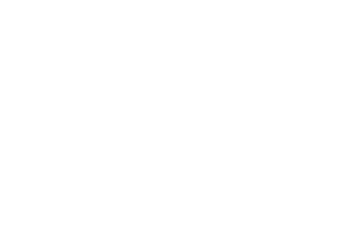


/theartnewspaper_long_text.csv
unique tags count: 76
unique tags count after updating: 76


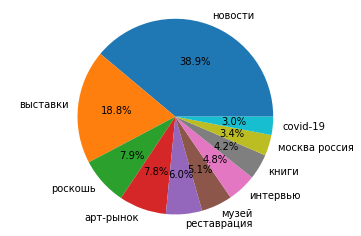


/artchive_long_text.csv
unique tags count: 11949
unique tags count after updating: 11949


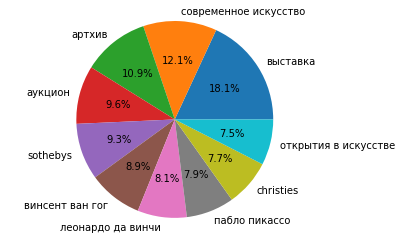


/artuzel_long_text.csv
unique tags count: 607
unique tags count after updating: 607


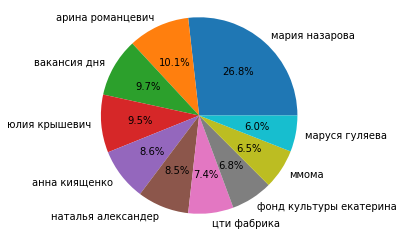

In [79]:
def by_value(item):
  return item[1]

name_list = list(combo_df_dict.keys())
for name in name_list:
  print(name)
  tags_count_dict = {tag: 0 for tag in total_tags_lists[name_list.index(name)]}
  print('unique tags count:', len(tags_count_dict))

  df = combo_df_dict[name]
  for tags_list in df.loc[df['tags_list_len']>0]['tags_list'].tolist(): # list of lists
    for tag in tags_list:
      tag_count = tags_count_dict[tag] + 1
      tags_count_dict.update({tag: tag_count})
  print('unique tags count after updating:', len(tags_count_dict))
  
  counts = []
  tags = []
  for k, v in sorted(tags_count_dict.items(), key=by_value, reverse=True)[:10]:
    counts.append(v)
    tags.append(k)

  fig, ax = plt.subplots()
  ax.pie(counts[:10], labels=tags[:10], autopct='%1.1f%%')
  ax.axis("equal")
  plt.show()
  #print(sample(el, 10))
  print('')

# /artuzel_long_text.csv - names are mostly of authors

## ...

In [70]:
save_df_file(theartnewspaper_w_text, theartnewspaper_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artuzel_news_articles_w_text, artuzel_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artchive_news_articles_w_text, artchive_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')
save_df_file(artinvest_news_articles_w_text, artinvest_w.replace('.csv', '') + '_' + str(datetime.now().date()) + '.csv', 'backup')